In [ ]:
# author: Jing
# date: May 24 2019
# function: survival analysis based on cox model, 
# plot results with seaborn ( plt.clf() to prevent plot accumulated), seaborn is slow 

In [669]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis

from sksurv.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
sns.set_style("whitegrid")
# generate the response variable for cox model
from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis


In [670]:
filename = "gene_mutations_clinical_mskcc.txt"
data_ = pd.read_csv(filename, sep = '\t')#, dtype = 'object')

d = {'LIVING': False, 'DECEASED': True}
data_["OS_STATUS"] = data_["OS_STATUS"].map(d)

data_y = data_[['OS_STATUS','OS_MONTHS']]

data_x = data_
data_x = data_x.drop(columns = ['Tumor_Sample_Barcode','PATIENT_ID','OS_MONTHS','OS_STATUS','ONCOTREE_CODE'])

#a = OneHotEncoder().fit_transform(data_x["SEX"])
x = encode_categorical(data_x)
y = Surv.from_dataframe(event='OS_STATUS', time='OS_MONTHS', data=data_)


In [640]:
data_x.shape

(1610, 480)

In [671]:
fn = "gene_mutations_mskcc.txt"
td = pd.read_csv(filename, sep = '\t')
td.shape

(1610, 485)

In [651]:
np.where(data_x.columns=='ABL1')

(array([0]),)

In [672]:
# uncomment to plot features
# for x in data_x.columns:
#     print(x)

In [691]:
# cox model on pan-cancer
estimator = CoxPHSurvivalAnalysis()
estimator.fit(x, y)

pd.Series(estimator.coef_, index=x.columns)
'''
sns.set(rc={'figure.figsize':(30,85)})

ax = sns.barplot(y = x.columns, x = estimator.coef_)
plt.savefig('./out/mskcc/Cox/cox_overall_linear.pdf')

ind = np.argsort(abs(estimator.coef_))
ind = ind[::-1]#reverse the order
sns.set(rc={'figure.figsize':(45,155)})
sns.set_context("paper", font_scale=3)
ax = sns.barplot(y = x.columns[ind], x = estimator.coef_[ind])
plt.savefig('./out/mskcc/Cox/cox_overall_linear_ordered.pdf')
'''
# REF: https://www.ncbi.nlm.nih.gov/pubmed/23539594 Cancer genome landscapes
#      the human protein atlas https://www.proteinatlas.org/ENSG00000105173-CCNE1/pathology
# GTF21 renal; HIST1H3H renal pancreatic(stomach) cervical; CCNE1 liver endometrial ovarian; knstrn renal pancreatic
# rragc liver; lyn liver; RRAS renal glioma lung; rac2 renal, breast;nthl1 colorectal breast prostate lung liver

'\nsns.set(rc={\'figure.figsize\':(30,85)})\n\nax = sns.barplot(y = x.columns, x = estimator.coef_)\nplt.savefig(\'./out/mskcc/Cox/cox_overall_linear.pdf\')\n\nind = np.argsort(abs(estimator.coef_))\nind = ind[::-1]#reverse the order\nsns.set(rc={\'figure.figsize\':(45,155)})\nsns.set_context("paper", font_scale=3)\nax = sns.barplot(y = x.columns[ind], x = estimator.coef_[ind])\nplt.savefig(\'./out/mskcc/Cox/cox_overall_linear_ordered.pdf\')\n'

In [667]:
# Run COXPHSurvival within cancer subtypes leading to error that matrix is singular
# mu, sigma = 0, 0.001
# noise = np.random.normal(mu, sigma, (x.shape))
# f = open("./out/mskcc/mskcc_gene_coxphsurvival.txt","w+")
# tpx = x + noise
# for cancer_type in ('Breast Cancer', 'Esophagogastric Cancer', 'Bladder Cancer',
#        'Non-Small Cell Lung Cancer', 'Glioma', 'Head and Neck Cancer',
#        'Melanoma', 'Colorectal Cancer', 'Renal Cell Carcinoma',
#        'Cancer of Unknown Primary'):#data_x["CANCER_TYPE"].unique():
#     mask = data_["CANCER_TYPE"] == cancer_type
#     ind = np.where(mask)[0].tolist()
#     tmpt = tpx.loc[mask]
#     tmpy = y[ind]
#     noise = np.random.normal(mu, sigma, (tmpt.shape))
#     tmpx  = tmpt + 2*noise
    
#     #print(tmpx.shape, tmpy.shape)
#     net = CoxPHSurvivalAnalysis() # L1
#     net.fit(tmpx, tmpy)
#     order = np.argsort((net.coef_))
#     order = order[::-1][0:50]
#     f.write(cancer_type + "\r" + str(np.count_nonzero(tmpt))+"\r" + str(x.columns[order].values)+'\n')
    
#     sns.set(rc={'figure.figsize':(15.7,20)})

#     ax = sns.barplot(y = x.columns[order], x = net.coef_[order])
#     plt.savefig('./out/mskcc/Cox/cox_' + cancer_type + '_addnoise2.pdf')

In [688]:
coxnet = CoxnetSurvivalAnalysis(n_alphas=100)#l1_ratio = 0.000001) # L1
coxnet.fit(x, y)

coxnet.score(x,y)


Exception: Data must be 1-dimensional

In [699]:
#
#plt.plot(coxnet.coef_[:,1])
coxnet.alphas_

array([4.08073438, 3.71821319, 3.38789737, 3.08692591, 2.81269192,
       2.56282012])

In [708]:
print(coxnet.alphas_.shape)
print(coxnet.deviance_ratio_)
print(coxnet.alphas_)
print(coxnet.alpha_min_ratio)
print(coxnet.tol)
ind = np.argsort((coxnet.coef_[:, -1]))
ind = ind[::-1] #reverse the order
# save the result

result=pd.DataFrame(data = coxnet.coef_, columns = coxnet.alphas_, index = x.columns)

result.to_csv('./out/mskcc/Cox/result_coxnet_overall_ordered.txt', sep='\t')
'''
# uncomment to plot the above result into figures

plt.clf()
sns.set(rc={'figure.figsize':(15.7,105)})

ax = sns.barplot(y = x.columns[ind], x = coxnet.coef_[:,-1][ind])
plt.savefig('./out/mskcc/Cox/coxnet_overall_ordered.pdf')
'''

(6,)
[-0.0060588  -0.00554036 -0.00507385 -0.00465585 -0.00428286 -0.00395138]
[4.08073438 3.71821319 3.38789737 3.08692591 2.81269192 2.56282012]
0.0001
1e-07


"\n# uncomment to plot the above result into figures\n\nplt.clf()\nsns.set(rc={'figure.figsize':(15.7,105)})\n\nax = sns.barplot(y = x.columns[ind], x = coxnet.coef_[:,-1][ind])\nplt.savefig('./out/mskcc/Cox/coxnet_overall_ordered.pdf')\n"

In [505]:
# write log file to recrod result
f = open("./out/mskcc/Cox/log_coxnetL2.txt","w+")
f.write("cancer\t\n")
f.write("---process %s seconds ---\n" % (23))
f.write("---process %s seconds ---\n" % (23))

26

In [710]:
all_time[0]=1
new_x.columns

Index(['ABL1', 'ACVR1', 'AGO2', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'ALOX12B',
       'AMER1', 'ANKRD11',
       ...
       'CANCER_TYPE=Breast Cancer', 'CANCER_TYPE=Cancer of Unknown Primary',
       'CANCER_TYPE=Colorectal Cancer', 'CANCER_TYPE=Esophagogastric Cancer',
       'CANCER_TYPE=Glioma', 'CANCER_TYPE=Head and Neck Cancer',
       'CANCER_TYPE=Melanoma', 'CANCER_TYPE=Non-Small Cell Lung Cancer',
       'CANCER_TYPE=Renal Cell Carcinoma',
       'CANCER_TYPE=Skin Cancer, Non-Melanoma'],
      dtype='object', length=492)

(1610,)
(41, 492)
---plot 2.64599609375 seconds ---
(1610,)
(118, 492)
---plot 2.7666709423065186 seconds ---
(1610,)
(211, 492)
---plot 2.735240936279297 seconds ---
(1610,)
(344, 492)
---plot 2.649031162261963 seconds ---
(1610,)
(116, 492)
---plot 2.809062957763672 seconds ---
(1610,)
(129, 492)
---plot 2.7574820518493652 seconds ---
(1610,)
(313, 492)
---plot 2.7979447841644287 seconds ---
(1610,)
(109, 492)


/usr/local/lib/python3.7/site-packages/scikit_survival-0.9.dev5+g9fdc0f7-py3.7-macosx-10.14-x86_64.egg/sksurv/linear_model/coxph.py:80: RuntimeWarning: overflow encountered in exp
  numpy.exp(- self.cum_baseline_hazard_.y))


---plot 2.6443910598754883 seconds ---
(1610,)
(143, 492)
---plot 2.7502028942108154 seconds ---
(1610,)
(85, 492)
---plot 2.8005998134613037 seconds ---


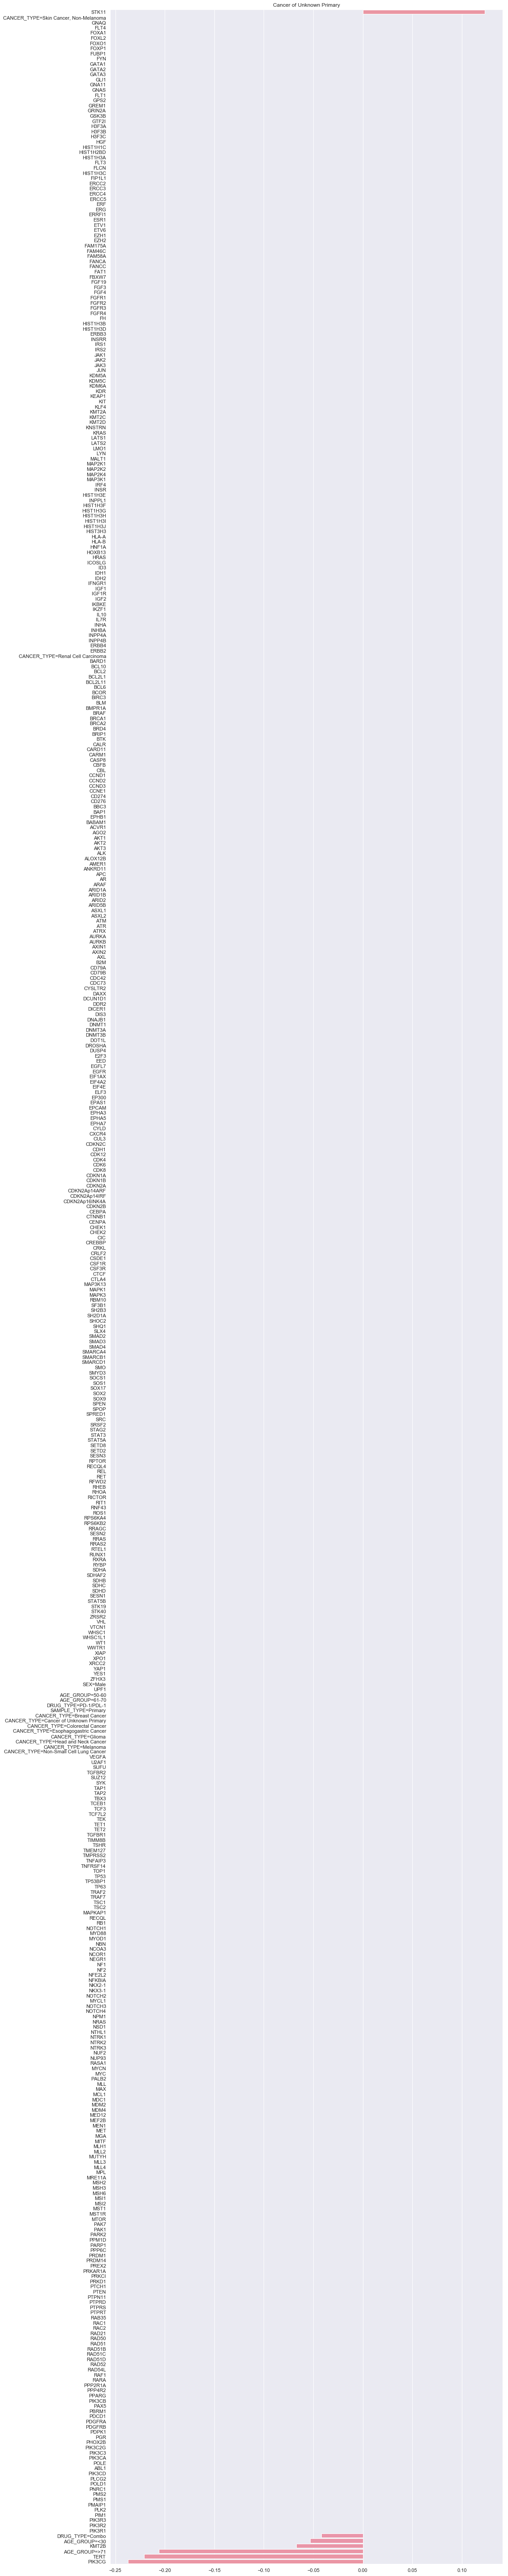

In [712]:
# within cancer COXNET without TMB_SCORE
import time
l1ratio = 0.95# 0 is L2; 1 is L1
f = open("./out/mskcc/Cox/log_coxnetL1_"+ str(l1ratio) + ".txt","w+")
proc_time = np.zeros((3,1))

new_x = x.drop(columns = "TMB_SCORE")
for cancer_type in ('Breast Cancer', 'Esophagogastric Cancer', 'Bladder Cancer',
       'Non-Small Cell Lung Cancer', 'Glioma', 'Head and Neck Cancer',
       'Melanoma', 'Colorectal Cancer', 'Renal Cell Carcinoma',
       'Cancer of Unknown Primary'): #data_x["CANCER_TYPE"].unique():
    processT = time.time()
    mask = data_["CANCER_TYPE"] == cancer_type
    print(mask.shape)
    ind= np.where(mask)[0].tolist()
    tmpx = new_x.loc[mask]
    print(tmpx.shape)
    tmpy = y[ind]
    f.write(cancer_type + "\t" + "sample size %d \t\n" % len(ind))
    proc_time[0] = time.time() - processT
    #print(tmpx.shape, tmpy.shape)
    
    modT = time.time()
    coxnet = CoxnetSurvivalAnalysis(l1_ratio=l1ratio,fit_baseline_model = True)#l1_ratio = 0.000001) # L1
    coxnet.fit(tmpx, tmpy)
    proc_time[1] = (time.time()-modT)
   
    
    sortT = time.time()
    coef = coxnet.coef_[:,-1]#pd.DataFrame(, index = new_x.columns, dtype=float)
    
    #print(coxnet.coef_[474,0],coxnet.coef_[474,1],coxnet.coef_[474,2],coxnet.coef_[474,3],coxnet.coef_[4,0])
    order = np.argsort(coef)
    order = order[::-1]
    proc_time[2] = (time.time()-sortT)

    result=pd.DataFrame(data = coxnet.coef_, columns = coxnet.alphas_, index = new_x.columns)

    result.to_csv('./out/mskcc/Cox/result_coxnet_' + cancer_type + '_L1ratio_'+str(l1ratio)+'.txt', sep='\t')
    pltT = time.time()
    plt.clf()
    #print(caner_type, x.columns[474])
    sns.set(rc={'figure.figsize':(30,105)})
    #sns.set_context("paper", font_scale=3)   
    ax = sns.barplot(y = new_x.columns[order], x = coef[order])
    ax.set(title=str(cancer_type))
    plt.savefig('./out/mskcc/Cox/coxnet_' + cancer_type + '_L1ratio_'+str(l1ratio)+'.pdf')
    print("---plot %s seconds ---" % (time.time() - pltT))
    f.write("---plot %6s seconds ---\n" % (time.time()-pltT))
    f.write("# nonzero "+ str(np.nonzero(coef)[0])+"\t\n")
    
    m = CoxnetSurvivalAnalysis()
    m.fit(tmpx.iloc[:, np.nonzero(coef)[0]],tmpy) # select  features 
    score = m.score(tmpx.iloc[:, np.nonzero(coef)[0]],tmpy)
    f.write("score %.6s \t\n" % score )
    f.write("nonzero %d \t\n" % np.count_nonzero(abs(coef)))
    for t in new_x.columns[np.nonzero(coef)[0]]:
          f.write(t + '\t')
    f.write("\n")
    f.write("---order %.6f, preprocess %.6f, coxnet %.6f ---\n" % (proc_time[0], proc_time[1], proc_time[2]))

    f.write('\n')


In [728]:
# cross validation to select number of features

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.datasets import load_veterans_lung_cancer
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([#('encode', OneHotEncoder()),
                 ('select', SelectKBest(fit_and_score_features, k=2)),
                 ('model', CoxnetSurvivalAnalysis())])# CoxnetSurvivalAnalysis())])CoxPHSurvivalAnalysis

In [731]:
new_x = x.drop(columns = "TMB_SCORE")
# 'Breast Cancer', 
for cancer_type in ('Non-Small Cell Lung Cancer', 'Esophagogastric Cancer', 'Bladder Cancer',
       'Glioma', 'Head and Neck Cancer',
       'Melanoma', 'Colorectal Cancer', 'Renal Cell Carcinoma',
       'Cancer of Unknown Primary'):
    print(cancer_type)
    mask = data_["CANCER_TYPE"] == cancer_type
    ind= np.where(mask)[0].tolist()
    tmpx = new_x.loc[mask]
    print(tmpx.shape)

    tmpy = y[ind]
    param_grid = {'select__k': np.arange(1, tmpx.shape[1] + 1)}
    gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=2, iid=True)
    gcv.fit(tmpx, tmpy)

    pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
    pd.to_csv('./out/mskcc/Cox_Cross/CV_' + cancer_type + ".txt", sep='\t')

Non-Small Cell Lung Cancer
(344, 492)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


LinAlgError: Matrix is singular.

In [591]:
# Feature Selection: Which Variable is Most Predictive

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(x.values, y)
fea_select = pd.Series(scores, index=x.columns).sort_values(ascending=False)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  from ipykernel import kernelapp as app


In [597]:
fea_select.to_csv('./out/mskcc/Cox/fit_and_score_features.txt', sep='\t')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
